In [2]:
#| default_exp model

In [13]:
#| export
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from dataclasses import dataclass

In [14]:
#| export
@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

GPT-2 模型的结构
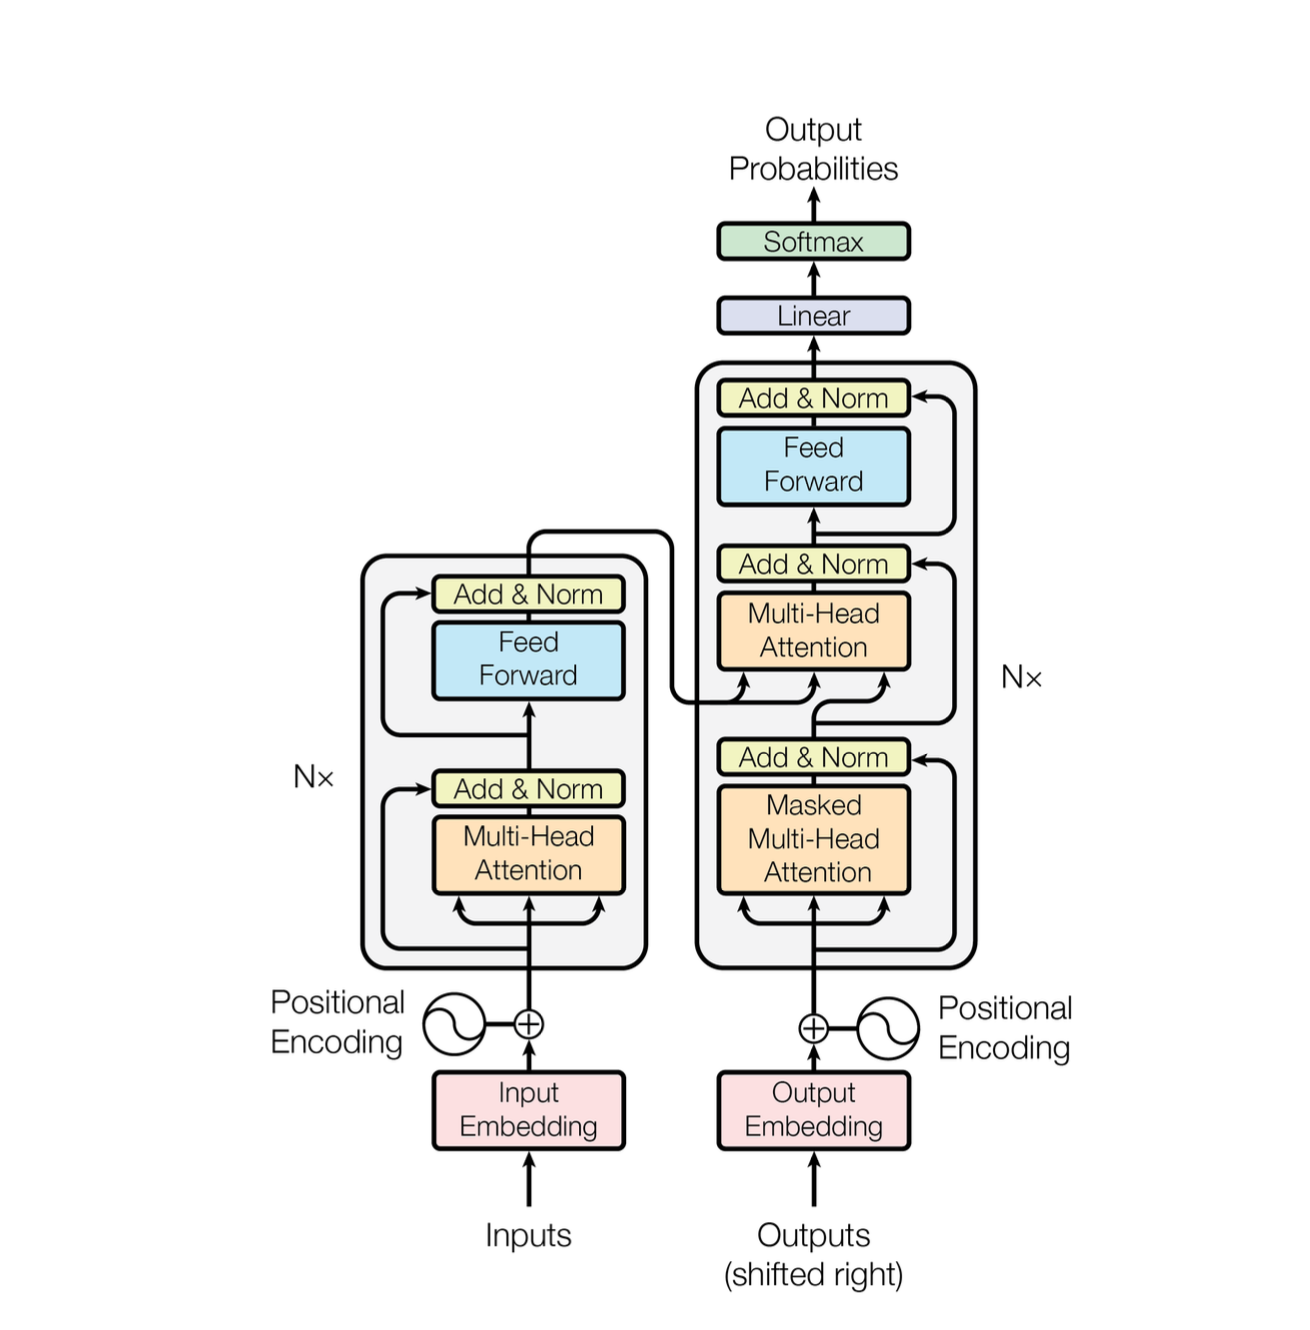
Block 是 multi-head attention block

In [15]:
config = GPTConfig()
b = torch.tril(torch.ones(config.block_size, config.block_size))
b.shape, b
b[None, None,:].shape

torch.Size([1, 1, 1024, 1024])

In [16]:
context = torch.zeros((1, 1000), dtype=torch.long)
idx_cond = context[:, -256:]
idx_cond.shape

torch.Size([1, 256])

GPT-2 的 attention block 和 transformer paper 中的实现略有不同
在 attention 之前也加了一层 layer norm

In [17]:
#| export
class Block(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) # residual connection
        x = x + self.mlp(self.ln_2(x)) # residual connection
        return x

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        # TODO: why we need this bias?
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, C) -> (B, T, nh, hs) -> (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y    

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [28]:
#| export
class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and position embeddings
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        x = tok_emb + pos_emb # broadcasting
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

# weight sharing scheme
transformer pager 中的实现 word embedding layer (wte) 和 output embedding (lm_head) 共享 weight:
1. similar tokens embedding 应该也相似, 模型中的 wte 和 lm_head 应该具备这种特性, 所以尝试 weight tie
2. 减少了大量参数, 模型训练效果更好 (50257 * 768 / 124M = 30%)


In [29]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

In [30]:
data = "Hello, I'm a language model,"
tokens = enc.encode(data)
print(tokens)

[15496, 11, 314, 1101, 257, 3303, 2746, 11]


In [31]:
tokens = torch.tensor(tokens)
tokens, tokens.shape

(tensor([15496,    11,   314,  1101,   257,  3303,  2746,    11]),
 torch.Size([8]))

In [32]:
x = tokens[:-1].to('cuda').unsqueeze(0)
y = tokens[1:].to('cuda').unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 7]), torch.Size([1, 7]))

In [33]:
#| export
def get_model():
    config = GPTConfig()
    model = GPT(config)
    return model

# 检查 model 初始化
我们可以根据 loss 判断 model 初始化情况, 正确初始化的 predict 应该符合 uniform distribution,
输出任意 token 的概率是 1/vocab_size

我们使用的 cross entropy loss $ -\sum y\, \log p(x) $ 等价于 nll (因为 y 是 one-hot encoding)

 所以模型初始的 loss 应该大致是: -ln(1/50257) = 10.8 

In [34]:

model = get_model().to("cuda")
logits, loss = model(x, y)
logits.shape, loss

(torch.Size([1, 7, 50257]),
 tensor(11.0053, device='cuda:0', grad_fn=<NllLossBackward0>))